# Shadow Map

This chapter outlines the shadow mapping process, employing ray tracing to precisely delineate the patterns of shadow flickering attributed to a wind park. Through this method, a reliable estimation is obtained, facilitating a good assessment of the potential impact of shadow flickering on neighboring residents in the vicinity of the wind park.

## What is Shadow Flicker?

Shadow flicker occurs when the sun shines through the rotating blades of a wind turbine, creating a dynamic shadow. This phenomenon raises concerns within nearby communities when the intermittent shadow from the turbine's rotating blades passes over buildings or homes, leading to the perception of a recurrent flicker with alternating light and dark periods through windows.

Given the specific sun angle required for this effect, shadow flicker is relatively uncommon, manifesting in restricted areas and lasting only a few hours annually. Nevertheless, when it does occur, it has the potential to become a nuisance for homeowners situated in close proximity to the turbines. Therefore, the government imposes stringent regulations on wind park developers to ensure that the impact of shadow flickering remains below specified thresholds (e.g., Denmark's limit of 10 hours per year) for neighboring residents. If instances arise where shadow flickering surpasses these defined limits, curtailment measures may become necessary.

<img src="../../jupyter-book/images/shadow-flicker.png" alt="shadow-flickering" width="300px" class="bg-primary"/>


*Fig 1: Shadow flickering becomes more pronounced in the evening due to the lower altitude of the sun, resulting in longer shadows cast by the turbines. ([Image Source](https://energyfollower.com/wind-turbine-shadow-flicker/))*

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.cython import solve_shadow_map
from src.utils import ElevationHandler, shadow_map_solver, import_point_source_data, calc_extent
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles
from matplotlib.colors import LogNorm

ModuleNotFoundError: No module named 'src.cython'

## Running the Script
To execute the shadow flickering calculator, the `shadow_map_solver` function requires details about the terrain elevation of the target area and specifications of the wind park turbines. This essential information is acquired by utilizing the `ElevationHandler` and `import_point_source_data` functions. The time frame for the shadow mapping is determined by setting the start and end dates. The script then runs the shadow mapping solver, producing a cumulative shadow map that includes the entire wind park. 

To generate an accurate shadow map, it is crucial to minimize the time interval between iterations to avoid creating gaps in the map. A default interval of freq = "10min" is currently used. To encompass the entire wind turbine rotor disc in the simulation, the rotor disc is approximated as a collection of points, each representing the starting point of a ray from the sun to the ground. To optimize simulation time, the minimum point density of the rotor disc is calculated based on terrain resolution and solar altitude angle.

To further expedite calculations, the main script has been converted to C using Cython. Despite these optimizations, the function remains computationally intensive, and the runtime can extend to several minutes depending on the number of turbines in the wind park and the terrain resolution.

## Displaying to Results

Once the script completes its iteration across individual wind turbines, the aggregated results can be visualized overlaid on an image from Google Maps.

### Wind Park Juurakko
Juurakko Wind Park, situated in Kalajoki, Finland, is a wind facility boasting a capacity of 40 MW. Constructed in 2022, it comprises seven Nordex N163 turbines, each with a capacity of 5.7 MW and a hub height reaching 148 meters and a rotor diameter of 163 meters {cite:p}`juurakko`.

In [2]:
point_source_data = import_point_source_data("Juurakko.json") # load wind park data
map_shape = [100, 100] # resolution of map data (in pixels)
dist = 3000 # distance from turbines to the edge of the map (in meters)
map_boundaries = calc_extent(point_source_data, dist) # calculate map boundaries (min/max longitude and latitude)
elevation_handler = ElevationHandler(map_boundaries, map_shape) # Initiate Elevation Handler (Takes care of the map downloads)
start_date = '2023-01-01 00:00:00' # Start date
end_date = '2023-12-31 23:59:59' # End date
processes = 4 # Processes for multiprocessing

cum_shadow_map, X, Y = shadow_map_solver(elevation_handler, point_source_data, start_date = start_date, end_date = end_date, processes = processes)

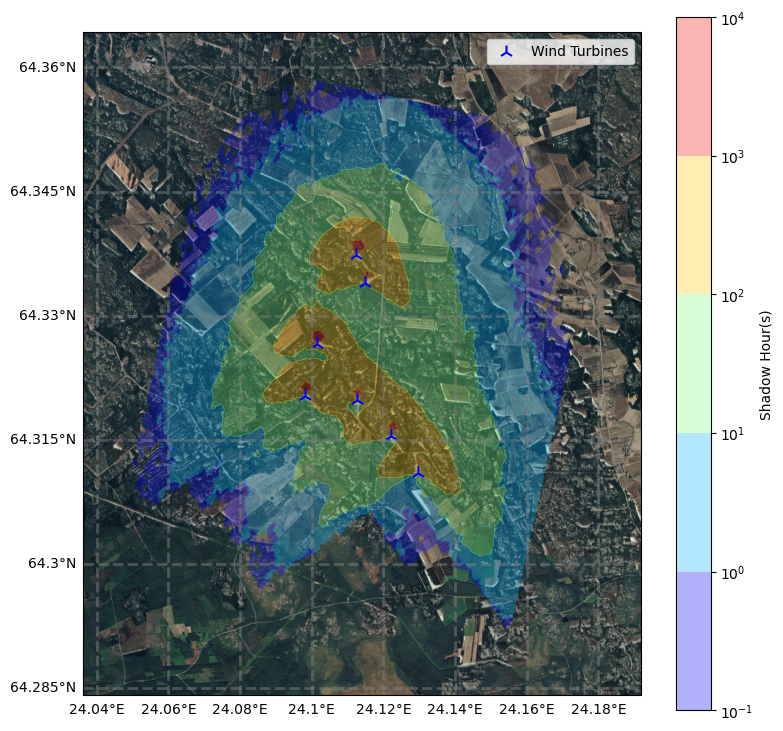

In [3]:
plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)

cp = ax.contourf(X, Y, cum_shadow_map, alpha = 0.3, cmap = "jet", transform=ccrs.PlateCarree(), norm=LogNorm())

ax.scatter(point_source_data.longitude, point_source_data.latitude, 
           marker = "2", color = "blue", s = 100, label = "Wind Turbines",
           transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label='Shadow Hour(s)')

ax.add_image(imagery, 14) # Deterine Image Resolution
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.legend()
plt.tight_layout
plt.show()

### Wind Park Prøvestenen
The Prøvestenen Wind Park, located in Copenhagen, Denmark, comprises three turbines with a combined capacity of 6.0 MW. The turbines utilized in this facility are the Vestas V80-2.0 MW VCS Mark 7 models, boasting a hub height of 67 meters and a rotor diameter of 80 meters. This wind park was established in the year 2013.

In [4]:
point_source_data = import_point_source_data("Prøvestenen.json") # load wind park data
map_shape = [100, 100] # resolution of map data (in pixels)
dist = 3000 # distance from turbines to the edge of the map (in meters)
map_boundaries = calc_extent(point_source_data, dist) # calculate map boundaries (min/max longitude and latitude)
elevation_handler = ElevationHandler(map_boundaries, map_shape) # Initiate Elevation Handler (Takes care of the map downloads)
start_date = '2023-01-01 00:00:00' # Start date
end_date = '2023-12-31 23:59:59' # End date
processes = 4 # Processes for multiprocessing

cum_shadow_map, X, Y = shadow_map_solver(elevation_handler, point_source_data, start_date = start_date, end_date = end_date, processes = processes)

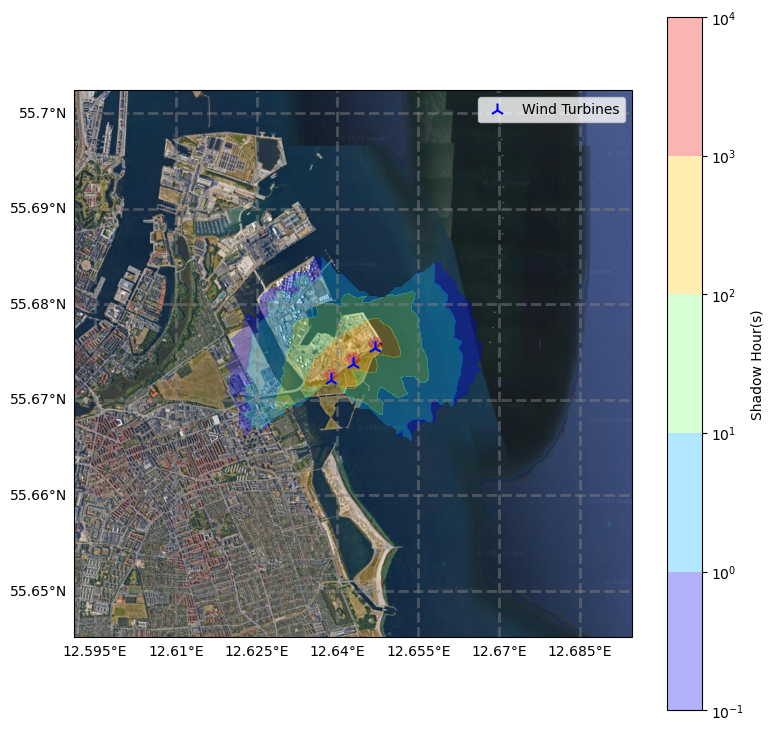

In [5]:
plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)

cp = ax.contourf(X, Y, cum_shadow_map, alpha = 0.3, cmap = "jet", transform=ccrs.PlateCarree(), norm=LogNorm())

ax.scatter(point_source_data.longitude, point_source_data.latitude, 
           marker = "2", color = "blue", s = 100, label = "Wind Turbines",
           transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label='Shadow Hour(s)')

ax.add_image(imagery, 14) # Deterine Image Resolution
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.legend()
plt.tight_layout
plt.show()

### Wind Park Østrup (Fictive)
Due to lack of shadow flickering map to easily compare against, a fictive wind park in Østrup Denmark was used for a low level comparison. The park consists of two Vestas V136 3.45 MW wind turbines with a hub height of 82 meters and a rotor diameter of 136 meters.

In [6]:
point_source_data = import_point_source_data("Østrup.json") # load wind park data
map_shape = [200, 200] # resolution of map data (in pixels)
dist = 2000 # distance from turbines to the edge of the map (in meters)
map_boundaries = calc_extent(point_source_data, dist) # calculate map boundaries (min/max longitude and latitude)
elevation_handler = ElevationHandler(map_boundaries, map_shape) # Initiate Elevation Handler (Takes care of the map downloads)
start_date = '2023-01-01 00:00:00' # Start date
end_date = '2023-12-31 23:59:59' # End date
processes = 10 # Processes for multiprocessing

cum_shadow_map, X, Y = shadow_map_solver(elevation_handler, point_source_data, start_date = start_date, end_date = end_date, processes = processes, freq="10min")

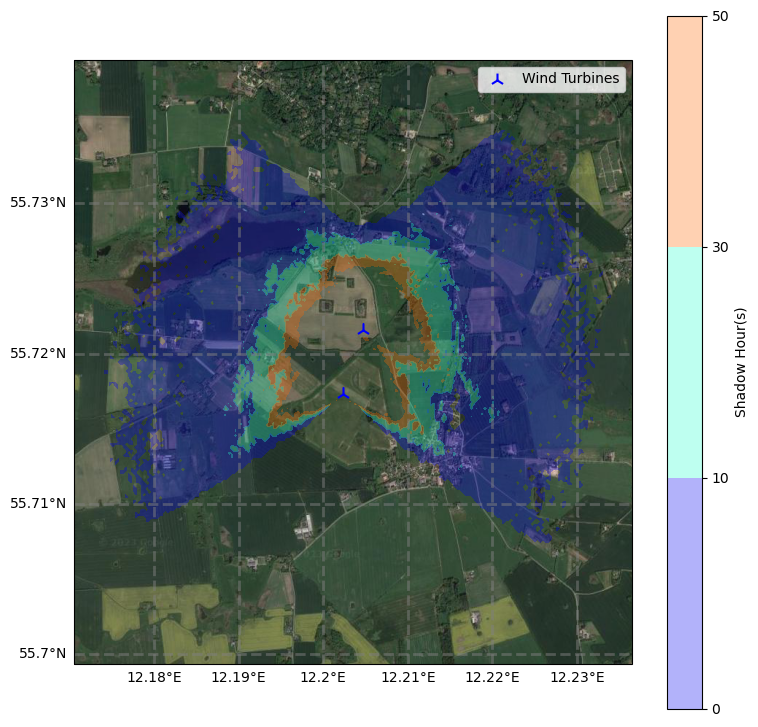

In [7]:
plt.figure(figsize=(9, 9))
imagery = GoogleTiles(style = "satellite")
ax = plt.axes(projection=imagery.crs)
ax.set_extent(map_boundaries)

levels = [0, 10, 30, 50]

cp = ax.contourf(X, Y, cum_shadow_map, alpha = 0.3, cmap = "jet", transform=ccrs.PlateCarree(),levels = levels)

ax.scatter(point_source_data.longitude, point_source_data.latitude, 
           marker = "2", color = "blue", s = 100, label = "Wind Turbines",
           transform=ccrs.PlateCarree())
plt.colorbar(cp, ax = ax, label='Shadow Hour(s)')

ax.add_image(imagery, 14) # Deterine Image Resolution
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

plt.legend()
plt.tight_layout
plt.show()

<img src="../../jupyter-book/images/shadow_flicker_ostrup.png" alt="shadow-flicker_ostrup" width="700px" class="bg-primary"/>


*Fig 2: Shadow flickering from fictive wind park in Ørstrup, Denmark calculated using WindPro.*

As seen from the comparison, it is clear that the calculated annual hours of shadow flickering align quite well between the two models. Nevertheless, the WindPro model anticipates a higher occurrence of shadow flickering, attributing it to the elongated shadows cast during the early and late hours of the day. This is likely a result of the applied solar altitude limit set at 5 degrees, where calculations cease if the sun's altitude falls below this threshold. This limit is in place to optimize computational efficiency. It may be beneficial to consider lowering this limit for enhanced accuracy in the results.